In [1]:
import pandas as pd
import os.path as op
import numpy as np
from risk_experiment.utils import get_all_behavior
from tqdm.contrib.itertools import product
import matplotlib.pyplot as plt
import pingouin
import seaborn as sns

/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [23]:
def get_pdf(subject, session, bids_folder='/data/ds-risk', mask='npcr', n_voxels=100, old=False):
    
    if n_voxels == 0:
        key = 'decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space'

        if old:
            key += '.bak'

        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_space-T1w_pars.tsv')
    else:
        key = 'decoded_pdfs.volume.denoise.natural_space'

        if old:
            key += '.bak'

        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_nvoxels-{n_voxels}_space-T1w_pars.tsv')

    if op.exists(pdf):
        return pd.read_csv(pdf, sep='\t', index_col=[0])
    else:
        print(pdf)
        return None

def get_decoding_info(subject, session, bids_folder='/data/ds-risk', mask='npcr', n_voxels=100, old=False):

    pdf = get_pdf(subject, session, bids_folder=bids_folder, mask=mask, n_voxels=n_voxels, old=old) 

    if pdf is not None:
        pdf.columns = pdf.columns.astype(float)

        E = (pdf*pdf.columns.values[np.newaxis, :] / pdf.sum(1).values[:, np.newaxis]).sum(1)
        E = pd.Series(np.trapz(pdf*pdf.columns.values[np.newaxis,:], pdf.columns, axis=1), index=pdf.index)

        E = pd.concat((E,), keys=[(subject, session, mask, n_voxels, old)],
        names=['subject', 'session', 'mask', 'n_voxels', 'old']).to_frame('E')

        E['sd'] = np.trapz(np.abs(E.values - pdf.columns.astype(float).values[np.newaxis, :]) * pdf, pdf.columns, axis=1)

        return E
    else:
        return pd.DataFrame(np.zeros((0, 0)))

In [28]:
from risk_experiment.utils.data import get_all_subject_ids
subjects = get_all_subject_ids()
sessions = ['3t2', '7t2']
masks = ['npcl', 'npcr']
n_voxels = [0, 100, 250][1:]
old = [False]
n_voxels = [0, 100, 250]

pred = []
pdfs = []
keys = []

for (sub, session, mask, nv, o) in product(subjects, sessions, masks, n_voxels, old):
    pred.append(get_decoding_info(sub, session, '/data/ds-risk', mask, nv, old=o))
    pdfs.append(get_pdf(sub, session, '/data/ds-risk', mask, nv, old=o))
    keys.append((sub, session, mask, nv, o))

pdfs = pd.concat(pdfs, keys=keys, names=['subject', 'session', 'mask', 'n_voxels', 'old'])

  0%|          | 0/360 [00:00<?, ?it/s]

In [29]:
pred = pd.concat(pred)
df = get_all_behavior(drop_no_responses=False, bids_folder='/data/ds-risk')
pred = pred.join(df, how='inner')

100%|██████████| 30/30 [00:01<00:00, 21.65it/s]


In [31]:
r1 = pred.groupby(['subject', 'session', 'mask', 'n_voxels', 'old']).apply(lambda d: pingouin.corr(d['E'], d['log(n1)']))
r2_ = pred.groupby(['subject', 'session', 'mask', 'n_voxels', 'run', 'old']).apply(lambda d: pingouin.corr(d['E'], d['log(n1)']))
r2 = r2_.groupby(['subject', 'session', 'mask', 'n_voxels', 'old']).mean()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_70119/2839759876.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r2 = r2_.groupby(['subject', 'session', 'mask', 'n_voxels', 'old']).mean()


In [44]:
sns.set_theme('paper', 'white', font='helvetica', font_scale=1.5, palette='tab10')

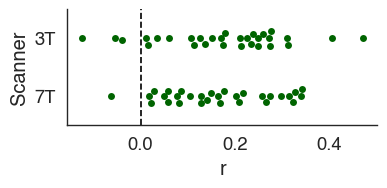

In [61]:
r2['Scanner'] = r2.index.get_level_values('session').map({'3t2':'3T', '7t2':'7T'})
sns.swarmplot(r2.xs(0, 0, 'n_voxels').xs('npcr', 0, 'mask'), x='r', y='Scanner', color='darkgreen')
plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(4, 1.5)
plt.savefig('/data/ds-risk/derivatives/figures/decoding_r.pdf', bbox_inches='tight')

In [51]:
pred['error'] = pred['n1'] - pred['E']
pred['abs(error)'] = np.abs(pred['error'])


r_error = pred.groupby(['subject', 'session', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['sd'], d['abs(error)']))

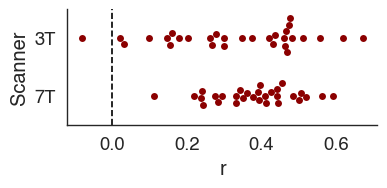

In [60]:
r_error['Scanner'] = r_error.index.get_level_values('session').map({'3t2':'3T', '7t2':'7T'})
sns.swarmplot(r_error.xs(0, 0, 'n_voxels').xs('npcr', 0, 'mask'), x='r', y='Scanner', color='darkred')
plt.axvline(0.0, c='k', ls='--')
sns.despine()
# plt.savefig()
plt.gcf().set_size_inches(4, 1.5)
# plt.title('Correlation decoded and real stimulus numerosity')
plt.savefig('/data/ds-risk/derivatives/figures/decoding_r_error.pdf', bbox_inches='tight')

In [46]:
r2.xs(0, 0, 'n_voxels')

n         r     p-val     power Scanner
subject session mask old                                              
02      3t2     npcl False  24.0  0.152712  0.460057  0.169813      3T
                npcr False  24.0  0.277480  0.242327  0.334180      3T
        7t2     npcl False  24.0  0.343526  0.186699  0.426796      7T
                npcr False  24.0  0.167875  0.426261  0.183939      7T
03      3t2     npcl False  24.0 -0.051541  0.618901  0.096496      3T
...                          ...       ...       ...       ...     ...
31      7t2     npcr False  24.0  0.265788  0.294920  0.332878      7T
32      3t2     npcl False  24.0  0.028698  0.634290  0.120125      3T
                npcr False  24.0 -0.053901  0.519518  0.157577      3T
        7t2     npcl False  24.0  0.232177  0.369169  0.281662      7T
                npcr False  24.0  0.323690  0.185225  0.383576      7T

[120 rows x 5 columns]

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


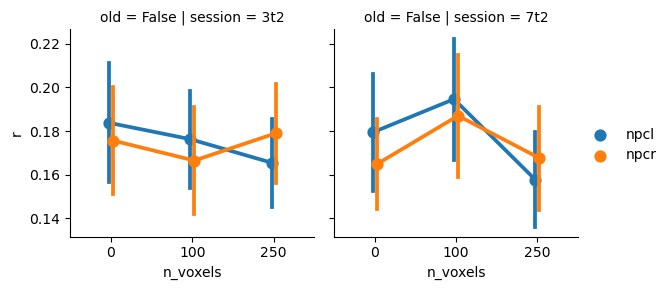

In [231]:
fac = sns.FacetGrid(col='session', data=r2.reset_index(), row='old')

fac.map(sns.pointplot, 'n_voxels', 'r', 'mask', hue_order=['npcl', 'npcr'], palette=sns.color_palette()[:2], dodge=True, errorbar='se')
fac.add_legend()

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


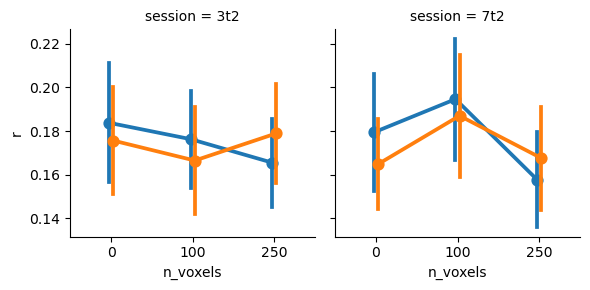

In [232]:
fac = sns.FacetGrid(col='session', data=r2.reset_index())

fac.map(sns.pointplot, 'n_voxels', 'r', 'mask', hue_order=['npcl', 'npcr'], palette=sns.color_palette()[:2], dodge=True, errorbar='se')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


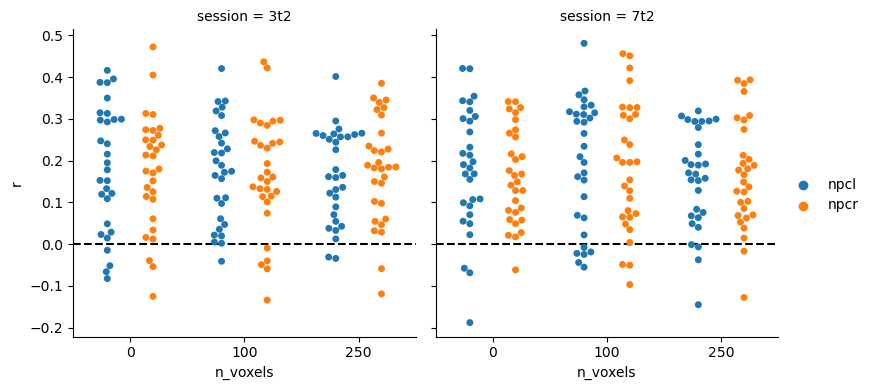

In [233]:
fac = sns.FacetGrid(col='session', data=r2.reset_index(), height=4)

fac.map(sns.swarmplot, 'n_voxels', 'r', 'mask', hue_order=['npcl', 'npcr'], palette=sns.color_palette()[:2], dodge=True)
fac.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))

fac.add_legend()

In [241]:
rs = r2.groupby(['session', 'mask', 'n_voxels']).mean()['r'].unstack(['mask', 'n_voxels']).round(3)
rs

mask       npcl                 npcr              
n_voxels    0      100    250    0      100    250
session                                           
3t2       0.184  0.176  0.166  0.176  0.167  0.179
7t2       0.179  0.195  0.158  0.165  0.187  0.168

In [210]:
pingouin.rm_anova(r2.xs('npcl', 0, 'mask').reset_index(), dv='r', within=['n_voxels', 'session'], subject='subject')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/distribution.py:481: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.groupby(level=1, axis=1, observed=True).diff(axis=1).dropna(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,n_voxels,0.017612,2,54,0.008806,2.269447,0.113143,0.126156,0.005834,0.787996
1,session,0.000408,1,27,0.000408,0.015265,0.902585,0.902585,0.000136,1.000000
2,n_voxels * session,0.005320,2,54,0.002660,0.760144,0.472537,0.471991,0.001770,0.995324


In [211]:
pingouin.rm_anova(r2.xs('npcr', 0, 'mask').reset_index(), dv='r', within=['n_voxels', 'session'], subject='subject')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/distribution.py:481: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.groupby(level=1, axis=1, observed=True).diff(axis=1).dropna(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,n_voxels,0.001278,2,58,0.000639,0.168799,0.845093,0.826558,0.000419,0.914850
1,session,0.000014,1,29,0.000014,0.000593,0.980747,0.980747,0.000005,1.000000
2,n_voxels * session,0.009997,2,58,0.004998,1.215767,0.303925,0.302610,0.003273,0.942894


In [212]:
pred['error'] = pred['n1'] - pred['E']
pred['abs(error)'] = np.abs(pred['error'])


r_error = pred.groupby(['subject', 'session', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['sd'], d['abs(error)']))

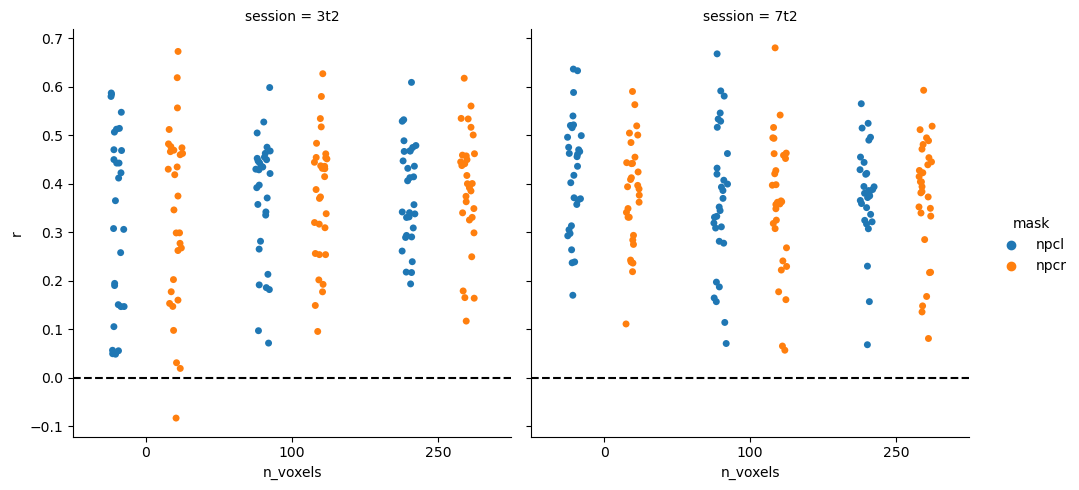

In [242]:
fac =  sns.catplot(r_error.reset_index(), x='n_voxels', y='r', col='session', hue='mask',  kind='strip', dodge=True, ci=67)

fac.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))

In [244]:
r_error.groupby(['mask', 'n_voxels', 'session'])['r'].mean().unstack(['mask', 'n_voxels']).round(3)

mask       npcl                 npcr              
n_voxels    0      100    250    0      100    250
session                                           
3t2       0.333  0.371  0.381  0.332  0.372  0.389
7t2       0.419  0.366  0.378  0.379  0.358  0.371

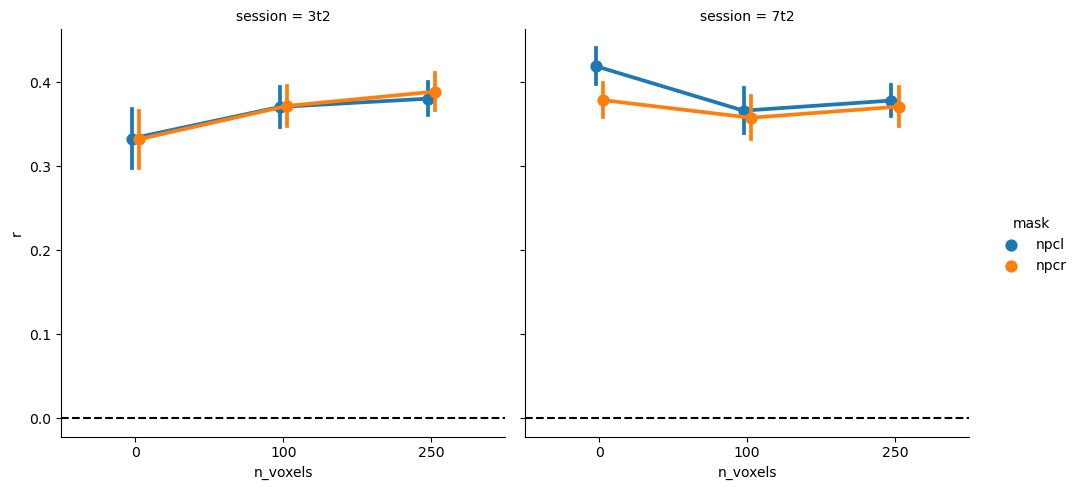

In [216]:
fac =  sns.catplot(r_error.reset_index(), x='n_voxels', y='r', col='session', hue='mask',  kind='point', dodge=True, errorbar='se')

fac.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))

In [217]:
import scipy.stats as ss

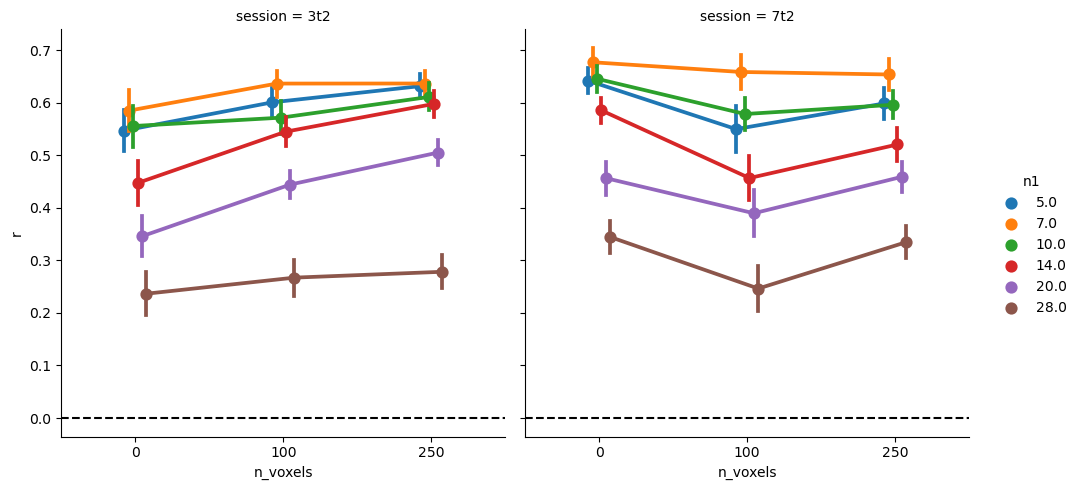

In [218]:
r_error2 = pred[~pred.risky_first].groupby(['subject', 'session', 'mask', 'n_voxels', 'n1']).apply(lambda d: pingouin.corr(d['sd'], d['abs(error)']))

fac =  sns.catplot(r_error2.reset_index(), x='n_voxels', y='r', hue='n1', col='session', kind='point', dodge=True, errorbar='se')

fac.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))

<AxesSubplot: xlabel='session-mask-n_voxels', ylabel='session-mask-n_voxels'>

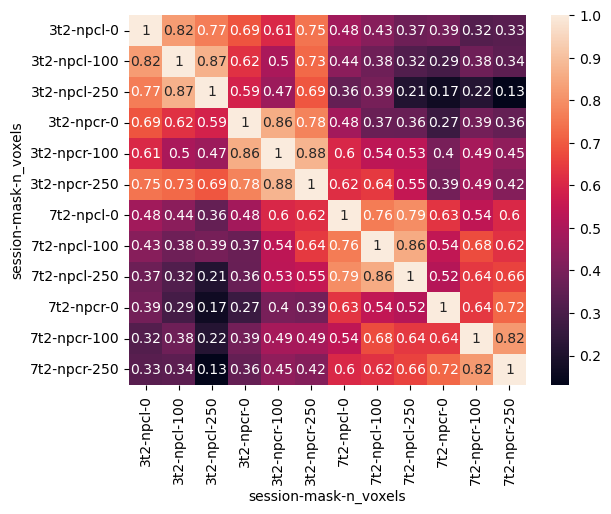

In [219]:
sns.heatmap(r2['r'].unstack(['session', 'mask', 'n_voxels']).corr(), annot=True)

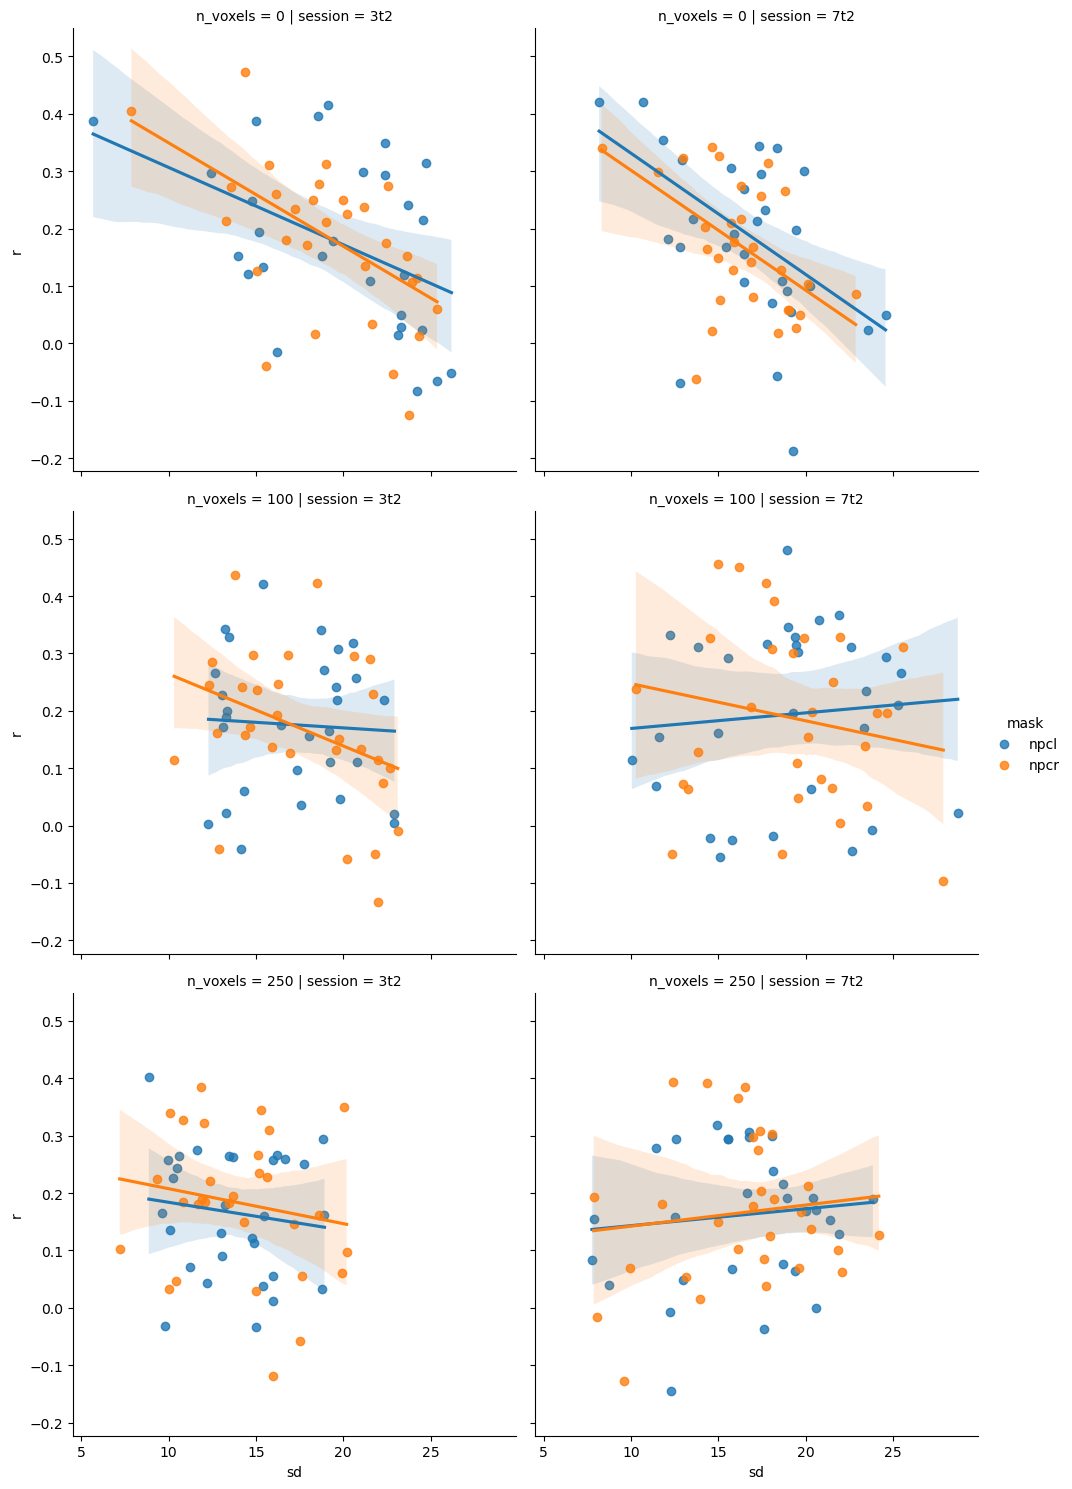

In [220]:
tmp = pred.groupby(['subject','session', 'mask', 'n_voxels'])[['sd']].mean().join(r2)

sns.lmplot(tmp.reset_index(), col='session', hue='mask', row='n_voxels', x='sd', y='r', robust=True)

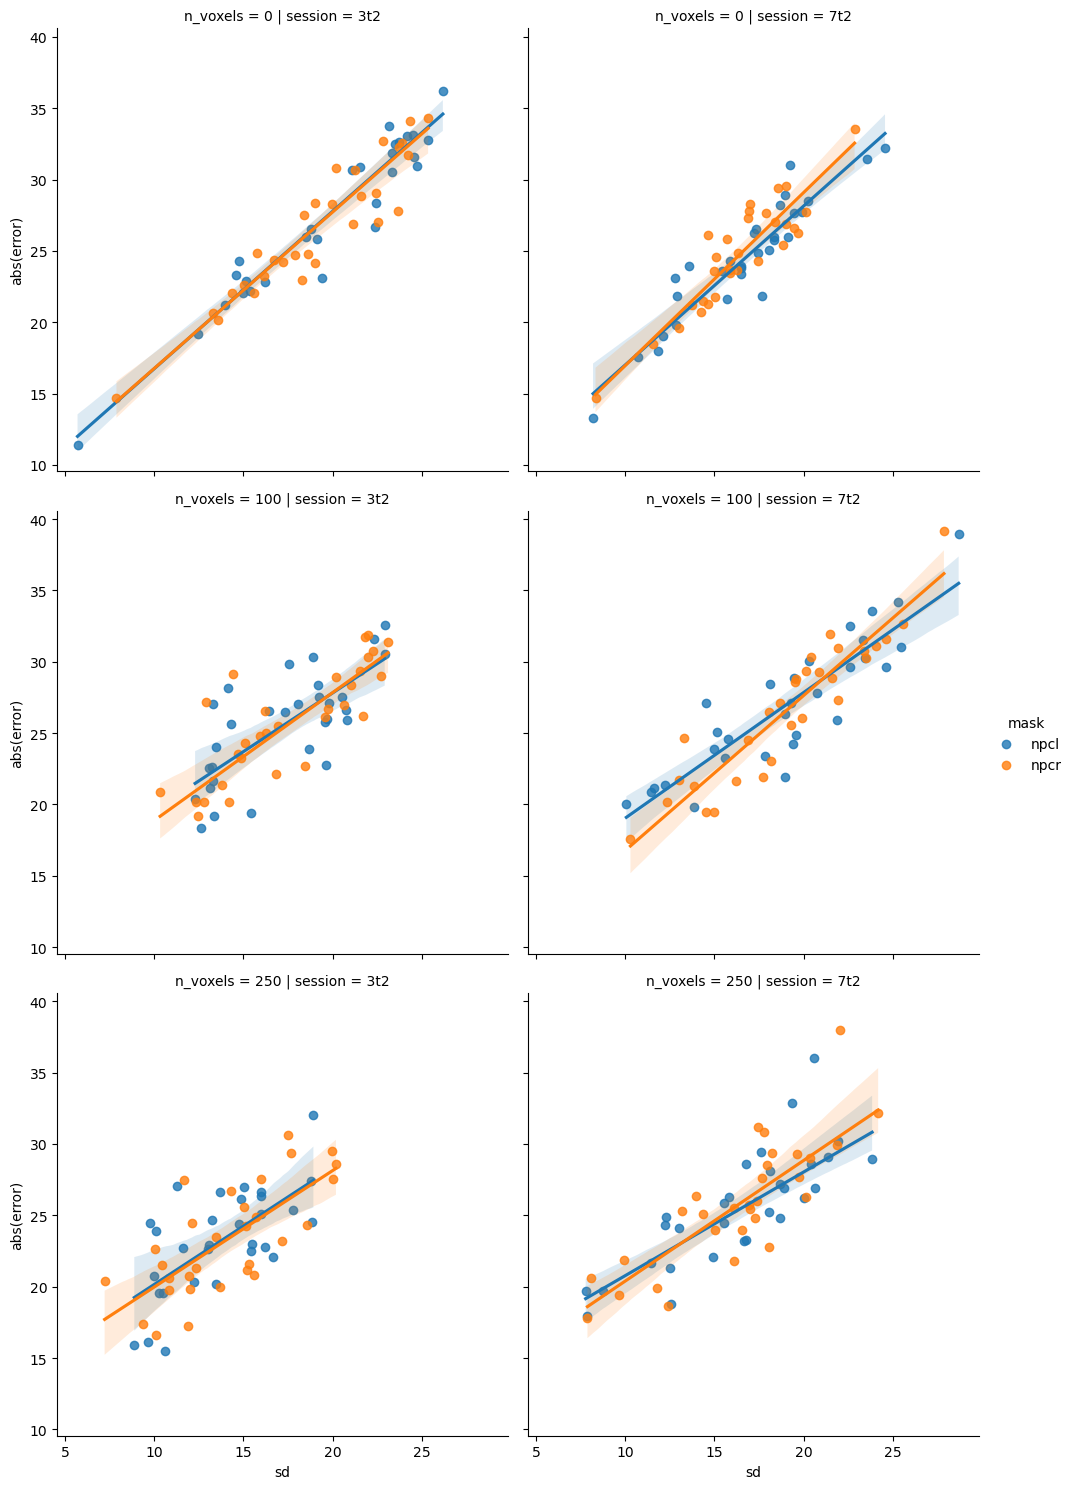

In [221]:
tmp = pred.groupby(['subject','session', 'mask', 'n_voxels'])[['sd', 'abs(error)']].mean()

sns.lmplot(tmp.reset_index(), col='session', hue='mask', row='n_voxels', x='sd', y='abs(error)', robust=True)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_49113/2737887354.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tmp.sort_values('sd'))


<AxesSubplot: ylabel='Density'>

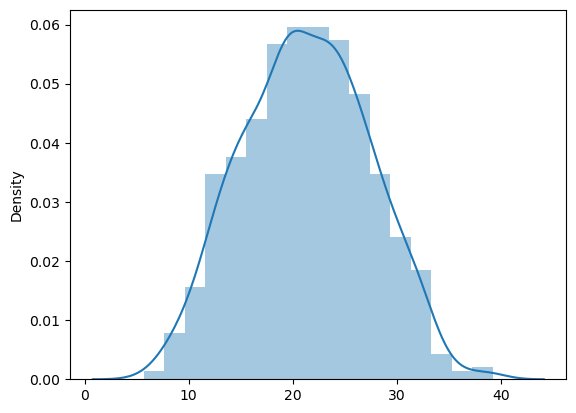

In [225]:
sns.distplot(tmp.sort_values('sd'))